In [1]:
import ipywidgets as widgets
import pandas as pd
import numpy as np
import seaborn as sns
import pycountry
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import IPython 
import IPython.display as display
%matplotlib inline

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('darkgrid')
sns.set_palette('colorblind')

In [2]:
LATEST_CASES_PATH_CSV = 'data/cases-per-day.csv'
LATEST_CASES_PATH_XLSX = 'data/cases-per-day.xlsx'

In [3]:
df = pd.read_excel(LATEST_CASES_PATH_XLSX, parse_dates=[0], encoding='iso-8859-1', index_col=0).rename(
    columns={
        'dateRep': 'date', 
        'countriesAndTerritories': 'geo_name', 
        'geoId': 'geo_id',
        'popData2018': 'pop_data_2018'
    },
    index={'dateRep': 'date'}
)
df.index.names = ['date']
df = df.drop(columns=['day', 'month', 'year', 'countryterritoryCode'])
df['geo_name'] = df['geo_name'].apply(lambda s: s.replace('_', ' '))

df

,cases,deaths,geo_name,geo_id,pop_data_2018,continentExp
date,,,,,,
2020-05-12,285,2,Afghanistan,AF,37172386.0,Asia
2020-05-11,369,5,Afghanistan,AF,37172386.0,Asia
2020-05-10,255,6,Afghanistan,AF,37172386.0,Asia
2020-05-09,215,3,Afghanistan,AF,37172386.0,Asia
2020-05-08,171,2,Afghanistan,AF,37172386.0,Asia
...,...,...,...,...,...,...
2020-03-25,0,0,Zimbabwe,ZW,14439018.0,Africa
2020-03-24,0,1,Zimbabwe,ZW,14439018.0,Africa
2020-03-23,0,0,Zimbabwe,ZW,14439018.0,Africa


In [4]:
lockdowns_raw = [
    ['2020-03-23', 'UK'],
    ['2020-03-01', 'IT'],
    ['2020-03-08', 'IT'],
    ['2020-03-15', 'ES']

]
lockdowns = pd.DataFrame(np.array(lockdowns_raw), columns=['lockdown_date', 'country_code'])
lockdowns['lockdown_date'] = lockdowns['lockdown_date'].apply(lambda d: np.datetime64(d))

lockdowns.set_index('lockdown_date', inplace=True)

lockdowns

,country_code
lockdown_date,
2020-03-23,UK
2020-03-01,IT
2020-03-08,IT
2020-03-15,ES


In [5]:
def rank_index(df):
    new_df = df.reset_index()
    new_df.index += 1
    
    return new_df.drop(columns=['index'])

In [6]:
aggregated = df.groupby(['geo_id', 'pop_data_2018', 'geo_name'], as_index=False)[['cases', 'deaths']].sum()

aggregated['cases_per_100k'] = aggregated['cases'] / (aggregated['pop_data_2018'] / 10 ** 5)
aggregated['deaths_per_100k'] = aggregated['deaths'] / (aggregated['pop_data_2018'] / 10 ** 5)
aggregated = aggregated.sort_values(by=['cases_per_100k'], ascending=False)
aggregated = rank_index(aggregated)

aggregated

,geo_id,pop_data_2018,geo_name,cases,deaths,cases_per_100k,deaths_per_100k
1,JPG11668,3000.0,Cases on an international conveyance Japan,696,7,23200.000000,233.333333
2,SM,33785.0,San Marino,628,41,1858.813083,121.355631
3,VA,1000.0,Holy See,12,0,1200.000000,0.000000
4,AD,77006.0,Andorra,756,48,981.741682,62.332805
5,QA,2781677.0,Qatar,23623,14,849.235911,0.503294
...,...,...,...,...,...,...,...
199,YE,28498687.0,Yemen,56,9,0.196500,0.031580
200,MR,4403319.0,Mauritania,8,1,0.181681,0.022710
201,BI,11175378.0,Burundi,19,1,0.170017,0.008948
202,AO,30809762.0,Angola,45,2,0.146058,0.006491


In [7]:
def make_per_100k_over_time(column, threshold):
    cum_column = f"cum_{column}"
    cum_100k_column = f"{column}_per_100k"
    
    def fn(country_code, df, threshold=threshold):
        cdf = df[(df['geo_id'] == country_code)]
        cdf = cdf.sort_index(ascending=True)
        cdf[cum_column] = cdf[column].cumsum()
        cdf[cum_100k_column] = cdf[cum_column] / (cdf['pop_data_2018'] / 10 ** 5)

        cdf = cdf[cdf[cum_column] > threshold]
        cdf = cdf.reset_index()

        return cdf
    
    return fn

def make_log_scale(column, column_name):
    def fn(df):
        df[column_name] = df[column].apply(lambda x: np.log10(x))
        
        return df
    
    return fn

cases_per_100k_over_time = make_per_100k_over_time('cases', 500)
deaths_per_100k_over_time = make_per_100k_over_time('deaths', 10)

cases_log_scale = make_log_scale('cum_cases', 'cum_cases_log')
deaths_log_scale = make_log_scale('cum_deaths', 'cum_deaths_log')

## Confirmed Cases

In [8]:
# Only consider countries with at least 1m citizens
larger_countries_cases_per_100k = aggregated[aggregated['pop_data_2018'] >= 10 ** 5]
larger_countries_cases_per_100k = larger_countries_cases_per_100k.sort_values(by=['cases_per_100k'], ascending=False)
larger_countries_cases_per_100k = rank_index(larger_countries_cases_per_100k)

larger_countries_cases_per_100k[['geo_name', 'cases_per_100k', 'cases', 'pop_data_2018']].head(60)

,geo_name,cases_per_100k,cases,pop_data_2018
1,Qatar,849.235911,23623,2781677.0
2,Luxembourg,639.759893,3888,607728.0
3,Iceland,509.370033,1801,353574.0
4,Spain,486.767447,227436,46723749.0
5,Ireland,476.665734,23135,4853506.0
6,Belgium,467.945034,53449,11422068.0
7,Singapore,421.854350,23787,5638676.0
8,United States of America,411.995773,1347916,327167434.0
9,Italy,363.742070,219814,60431283.0
10,Switzerland,355.320228,30261,8516543.0


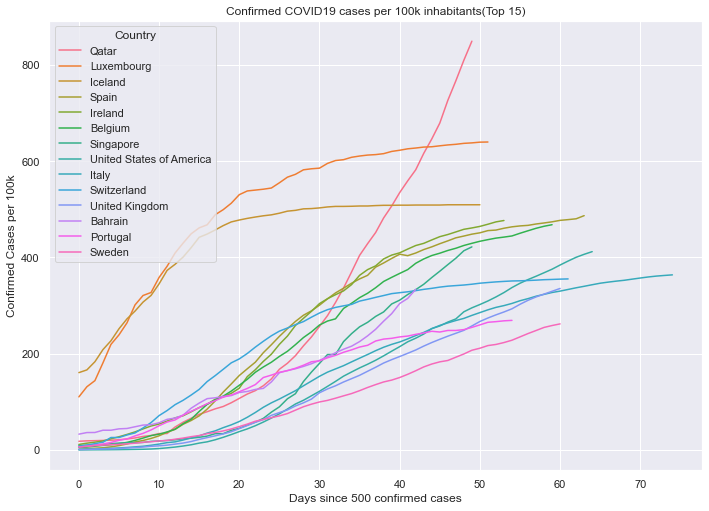

In [9]:
countries = larger_countries_cases_per_100k['geo_id'].head(15)
frames = [cases_per_100k_over_time(country, df) for country in countries]
plot_df = pd.concat(frames)

ax = sns.lineplot(
    x=plot_df.index, 
    y='cases_per_100k',
    hue='geo_name',
    legend='full',
    data=plot_df
)
ax.set(title='Confirmed COVID19 cases per 100k inhabitants(Top 15)')
ax.set(xlabel='Days since 500 confirmed cases')
ax.set(ylabel='Confirmed Cases per 100k')
labels = ax.get_legend().get_texts()
ax.legend(title='Country', loc='best', labels=[label.get_text() for label in labels[1:]])

plt.show()

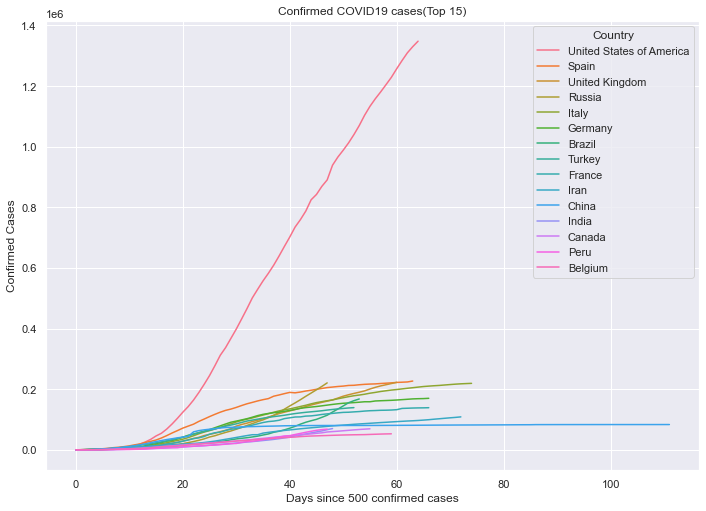

In [10]:
countries = aggregated.sort_values(by=['cases'], ascending=False)
countries = rank_index(countries)

countries = countries['geo_id'].head(15)
frames = [cases_per_100k_over_time(country, df) for country in countries]
plot_df = pd.concat(frames)

ax = sns.lineplot(
    x=plot_df.index, 
    y='cum_cases',
    hue='geo_name',
    legend='full',
    data=plot_df
)
ax.set(title='Confirmed COVID19 cases(Top 15)')
ax.set(xlabel='Days since 500 confirmed cases')
ax.set(ylabel='Confirmed Cases')
labels = ax.get_legend().get_texts()
ax.legend(title='Country', loc='best', labels=[label.get_text() for label in labels[1:]])

plt.show()

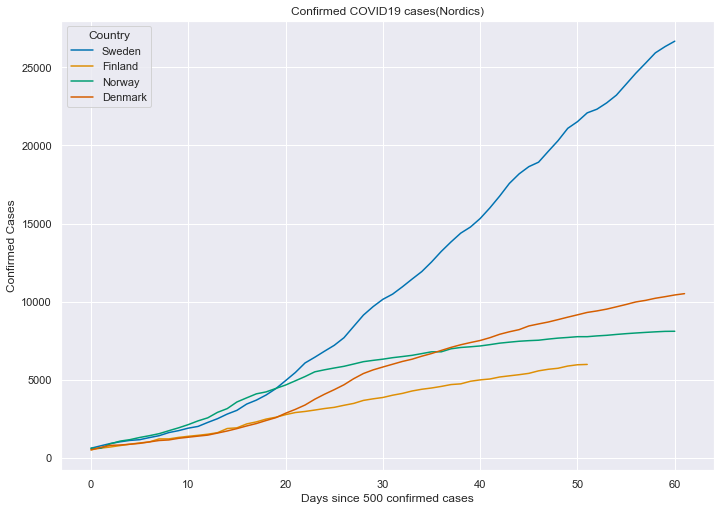

In [11]:
countries = aggregated.sort_values(by=['cases'], ascending=False)
countries = rank_index(countries)

countries = ['SE', 'FI', 'NO', 'DK']
frames = [cases_per_100k_over_time(country, df) for country in countries]
plot_df = pd.concat(frames)

ax = sns.lineplot(
    x=plot_df.index, 
    y='cum_cases',
    hue='geo_name',
    legend='full',
    data=plot_df
)
ax.set(title='Confirmed COVID19 cases(Nordics)')
ax.set(xlabel='Days since 500 confirmed cases')
ax.set(ylabel='Confirmed Cases')
labels = ax.get_legend().get_texts()
ax.legend(title='Country', loc='best', labels=[label.get_text() for label in labels[1:]])

plt.show()

In [12]:
@widgets.interact(
    country_code=widgets.Dropdown(
        options=[(name, geo_id) for (name, geo_id) in aggregated[['geo_name', 'geo_id']].to_records(index=False)],
        value='US',
        description='Country:',
    ),
    threshold=widgets.IntSlider(min=0, max=1000, step=1, value=500)
)
def plot(country_code, threshold=10):
    code = country_code
    lockdowns_for_country = lockdowns[lockdowns['country_code'] == code]
    per_100k = cases_per_100k_over_time(code, df, threshold).set_index('date').join(lockdowns_for_country).reset_index()
    log_scale = cases_log_scale(per_100k)
    if per_100k.empty:
        display.display(display.Markdown('# No Data for the selected filters'))
        return
    
    lockdown_days = per_100k.index[per_100k['country_code'] == code].to_list()
    country_name = per_100k.iloc[0]['geo_name']
    
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 6), tight_layout=True)
    plots = [{
        'title': f"Confirmed COVID-19 cases ({country_name})",
        'ylabel': f"Confirmed Cases",
        'df': per_100k,
        'ycolumn': 'cum_cases',
        'x': 0,
        'y': 0,
        'plot_type': 'line',
    }, {
        'title': f"Confirmed COVID-19 cases log scale({country_name})",
        'ylabel': f"Cases",
        'df': log_scale,
        'ycolumn': 'cum_cases_log',
        'x': 1,
        'y': 0,
        'plot_type': 'line',
    }, {
        'title': f"Confirmed COVID19 cases per 100k inhabitants({country_name})",
        'ylabel': f"Cases per 100k",
        'df': per_100k,
        'ycolumn': 'cases_per_100k',
        'x': 0,
        'y': 1,
        'plot_type': 'line',
    }, {
        'title': f"COVID19 cases per day({country_name})",
        'ylabel': f"New cases per day",
        'df': per_100k,
        'ycolumn': 'cases',
        'x': 1,
        'y': 1,
        'plot_type': 'bar',
    }]

    for plot_data in plots:
        plot_type = plot_data['plot_type']
        
        ax = None
        if plot_type == 'bar':
            ax = sns.barplot(
                x=plot_data['df'].index, 
                y=plot_data['ycolumn'],
                data=plot_data['df'],
                ax=axs[plot_data['y']][plot_data['x']]
            )            
        else:
            ax = sns.lineplot(
                x=plot_data['df'].index, 
                y=plot_data['ycolumn'],
                legend='full',
                data=plot_data['df'],
                ax=axs[plot_data['y']][plot_data['x']]
            )

        if len(lockdown_days) > 0:
            for lockdown_day in lockdown_days: 
                ax.axvline(lockdown_day, label="Lockdown", alpha=0.5, color='r', linestyle='--')

        ax.set(title=plot_data['title'])
        ax.set(xlabel=f"Days since {threshold} cases")
        ax.set(ylabel=plot_data['ylabel'])
        

interactive(children=(Dropdown(description='Country:', index=12, options=(('Cases on an international conveyan…

## Deaths

In [13]:
# Only consider countries with at least 1m citizens
larger_countries_deaths_per_100k = aggregated[aggregated['pop_data_2018'] >= 10 ** 6]
larger_countries_deaths_per_100k = larger_countries_deaths_per_100k.sort_values(by=['deaths_per_100k'], ascending=False)
larger_countries_deaths_per_100k = rank_index(larger_countries_deaths_per_100k)

larger_countries_deaths_per_100k[['geo_name', 'deaths_per_100k', 'deaths', 'pop_data_2018']].head(60)

,geo_name,deaths_per_100k,deaths,pop_data_2018
1,Belgium,76.229628,8707,11422068.0
2,Spain,57.238558,26744,46723749.0
3,Italy,50.866039,30739,60431283.0
4,United Kingdom,48.226029,32065,66488991.0
5,France,39.773244,26643,66987244.0
6,Sweden,31.974311,3256,10183175.0
7,Netherlands,31.663830,5456,17231017.0
8,Ireland,30.225573,1467,4853506.0
9,United States of America,24.661379,80684,327167434.0
10,Switzerland,18.105938,1542,8516543.0


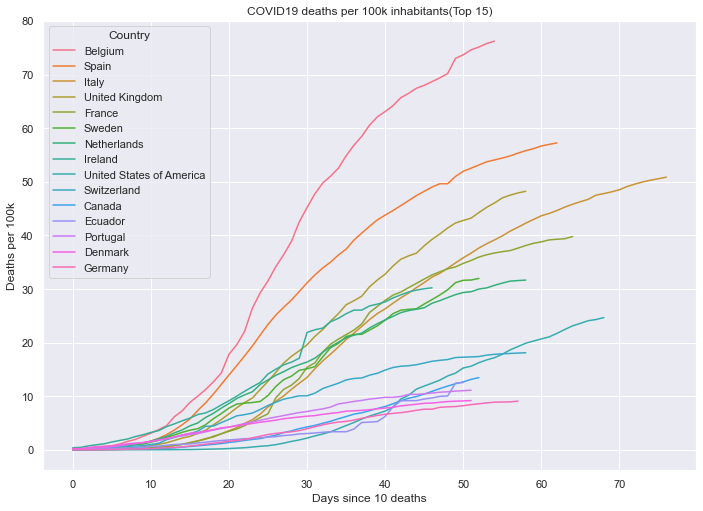

In [14]:
countries = larger_countries_deaths_per_100k['geo_id'].head(15)
#countries = ['SE', 'DK', 'NO', 'FI']
frames = [deaths_per_100k_over_time(country, df) for country in countries]
plot_df = pd.concat(frames)

ax = sns.lineplot(
    x=plot_df.index, 
    y='deaths_per_100k',
    hue='geo_name',
    legend='full',
    data=plot_df
)
ax.set(title='COVID19 deaths per 100k inhabitants(Top 15)')
ax.set(xlabel='Days since 10 deaths')
ax.set(ylabel='Deaths per 100k')
labels = ax.get_legend().get_texts()
ax.legend(title='Country', loc='best', labels=[label.get_text() for label in labels[1:]])
plt.show()

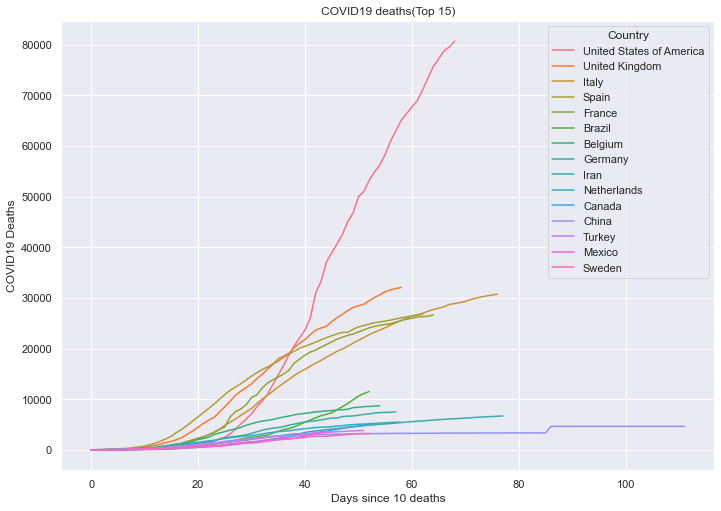

In [15]:
countries = aggregated.sort_values(by=['deaths'], ascending=False)
countries = rank_index(countries)

countries = countries['geo_id'].head(15)
frames = [deaths_per_100k_over_time(country, df) for country in countries]
plot_df = pd.concat(frames)

ax = sns.lineplot(
    x=plot_df.index, 
    y='cum_deaths',
    hue='geo_name',
    legend='full',
    data=plot_df
)
ax.set(title='COVID19 deaths(Top 15)')
ax.set(xlabel='Days since 10 deaths')
ax.set(ylabel='COVID19 Deaths')
labels = ax.get_legend().get_texts()
ax.legend(title='Country', loc='best', labels=[label.get_text() for label in labels[1:]])

plt.show()

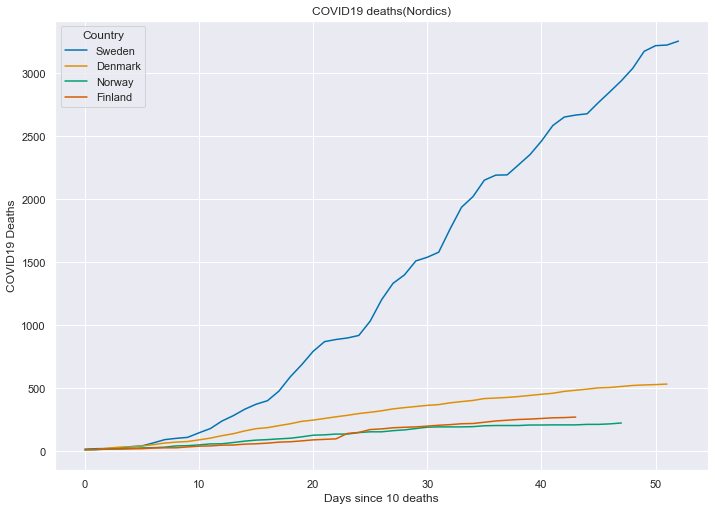

In [16]:
countries = aggregated.sort_values(by=['deaths'], ascending=False)
countries = rank_index(countries)

countries = ['SE', 'DK', 'NO', 'FI']
frames = [deaths_per_100k_over_time(country, df) for country in countries]
plot_df = pd.concat(frames)

ax = sns.lineplot(
    x=plot_df.index, 
    y='cum_deaths',
    hue='geo_name',
    legend='full',
    data=plot_df
)
ax.set(title='COVID19 deaths(Nordics)')
ax.set(xlabel='Days since 10 deaths')
ax.set(ylabel='COVID19 Deaths')
labels = ax.get_legend().get_texts()
ax.legend(title='Country', loc='best', labels=[label.get_text() for label in labels[1:]])

plt.show()

In [17]:
@widgets.interact(
    country_code=widgets.Dropdown(
        options=[(name, geo_id) for (name, geo_id) in aggregated[['geo_name', 'geo_id']].to_records(index=False)],
        value='US',
        description='Country:',
    ),
    threshold=widgets.IntSlider(min=0, max=1000, step=1, value=10)
)
def plot(country_code, threshold=10):
    code = country_code
    lockdowns_for_country = lockdowns[lockdowns['country_code'] == code]
    per_100k = deaths_per_100k_over_time(code, df, threshold).set_index('date').join(lockdowns_for_country).reset_index()
    log_scale = deaths_log_scale(per_100k)
    if per_100k.empty:
        display.display(display.Markdown('# No Data for the selected filters'))
        return
    
    lockdown_days = per_100k.index[per_100k['country_code'] == code].to_list()
    country_name = per_100k.iloc[0]['geo_name']
    
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 6), tight_layout=True)
    plots = [{
        'title': f"COVID-19 deaths({country_name})",
        'ylabel': f"Deaths",
        'df': per_100k,
        'ycolumn': 'cum_deaths',
        'x': 0,
        'y': 0,
        'plot_type': 'line',
    }, {
        'title': f"COVID-19 deaths log scale({country_name})",
        'ylabel': f"Deaths",
        'df': log_scale,
        'ycolumn': 'cum_deaths_log',
        'x': 1,
        'y': 0,
        'plot_type': 'line',
    }, {
        'title': f"COVID19 death per 100k inhabitants({country_name})",
        'ylabel': f"Deaths per 100k",
        'df': per_100k,
        'ycolumn': 'deaths_per_100k',
        'x': 0,
        'y': 1,
        'plot_type': 'line',
    }, {
        'title': f"COVID19 death per day({country_name})",
        'ylabel': f"Deaths per day",
        'df': per_100k,
        'ycolumn': 'deaths',
        'x': 1,
        'y': 1,
        'plot_type': 'bar',
    }]

    for plot_data in plots:
        plot_type = plot_data['plot_type']
        
        ax = None
        if plot_type == 'bar':
            ax = sns.barplot(
                x=plot_data['df'].index, 
                y=plot_data['ycolumn'],
                data=plot_data['df'],
                ax=axs[plot_data['y']][plot_data['x']]
            )            
        else:
            ax = sns.lineplot(
                x=plot_data['df'].index, 
                y=plot_data['ycolumn'],
                legend='full',
                data=plot_data['df'],
                ax=axs[plot_data['y']][plot_data['x']]
            )

        if len(lockdown_days) > 0:
            for lockdown_day in lockdown_days: 
                ax.axvline(lockdown_day, label="Lockdown", alpha=0.5, color='r', linestyle='--')

        ax.set(title=plot_data['title'])
        ax.set(xlabel=f"Days since {threshold} deaths")
        ax.set(ylabel=plot_data['ylabel'])
        

interactive(children=(Dropdown(description='Country:', index=12, options=(('Cases on an international conveyan…